In [1]:
#standard import
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

### Data Acquisition
The data was downloaded from Kaggle as a csv file.

In [2]:
#read csv from repo
df = pd.read_csv("GlobalLandTemperaturesByState.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


### Data Preparation

Analyse city of Hawaii only

In [4]:
#we will pick Hawaii
df = df[df.State == "Hawaii"].reset_index(drop = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             1569 non-null   object 
 1   AverageTemperature             1567 non-null   float64
 2   AverageTemperatureUncertainty  1567 non-null   float64
 3   State                          1569 non-null   object 
 4   Country                        1569 non-null   object 
dtypes: float64(2), object(3)
memory usage: 61.4+ KB


    2 columns has nulls, will drop them later on
    Average temperature is in degree celsuis 

In [6]:
#peek at data
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1883-01-01,20.248,1.002,Hawaii,United States
1,1883-02-01,20.139,1.760,Hawaii,United States
2,1883-03-01,20.508,0.841,Hawaii,United States
3,1883-04-01,21.751,2.459,Hawaii,United States
4,1883-05-01,22.553,1.854,Hawaii,United States


In [7]:
#drop state and country
df = df.drop(columns = ["State", "Country"])


In [8]:
#rename columns
df = df.rename(columns = {"dt":"date", "AverageTemperature": "average_temp", "AverageTemperatureUncertainty":"average_temp_uncertainity"})

In [9]:
#null check
df.isnull().sum()

date                         0
average_temp                 2
average_temp_uncertainity    2
dtype: int64

In [10]:
#we only have 4 null columns, we will drop them
df = df.dropna()

In [11]:
#final null check
df.isnull().sum().sum()

0

In [12]:
#lets see if the dates are unqiue
df.date.nunique(), df.shape[0]

(1567, 1567)

    each row represents average temperature of each month

In [13]:
#change date format to datetime64
df.date = pd.to_datetime(df.date)

In [14]:
#index the date and sort it
df = df.set_index("date").sort_index()

In [15]:
#when does date start and end
df.index.min(),df.index.max()

(Timestamp('1883-01-01 00:00:00'), Timestamp('2013-08-01 00:00:00'))

[]

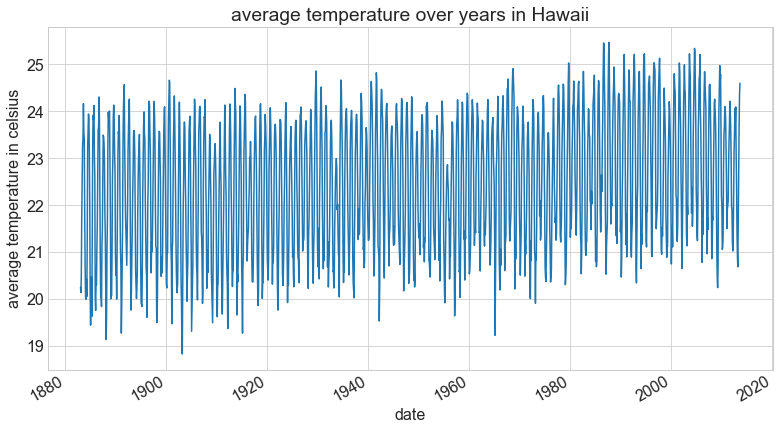

In [16]:
#plot average temperature over years
df.average_temp.plot(title ="average temperature over years in Hawaii", ylabel = "average temperature in celsius")
plt.plot()

#### I will analyse only data from 2003-01-01 onward

In [17]:
#we will analayse from 2003
df = df["2003-01-01":]

In [18]:
#check shape
df.shape

(128, 2)

In [19]:
#add year, month adn week day column
df['year'] = df.index.year
df['month'] = df.index.month_name()
df['weekday'] = df.index.day_name()

In [20]:
#peek data
df.head(2)

,average_temp,average_temp_uncertainity,year,month,weekday
date,,,,,
2003-01-01,21.337,0.171,2003,January,Wednesday
2003-02-01,21.132,0.254,2003,February,Saturday


#### Split data

In [21]:
#Split data
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

#### Verify the splits

In [22]:
#concat last row of train with first of validate
#they should only be a month apart
pd.concat([train.tail(1), validate.head(1)])

,average_temp,average_temp_uncertainity,year,month,weekday
date,,,,,
2008-04-01,21.687,0.153,2008,April,Tuesday
2008-05-01,22.704,0.323,2008,May,Thursday


In [23]:
#concat last row of validate with first of test
#they should only be a month apart
pd.concat([validate.tail(1), test.head(1)])

,average_temp,average_temp_uncertainity,year,month,weekday
date,,,,,
2011-06-01,23.334,0.312,2011,June,Wednesday
2011-07-01,23.681,0.299,2011,July,Friday


In [24]:
#also, sum of length of must equal to sum of df
 
len(train) + len(validate) + len(test) == len(df)

True

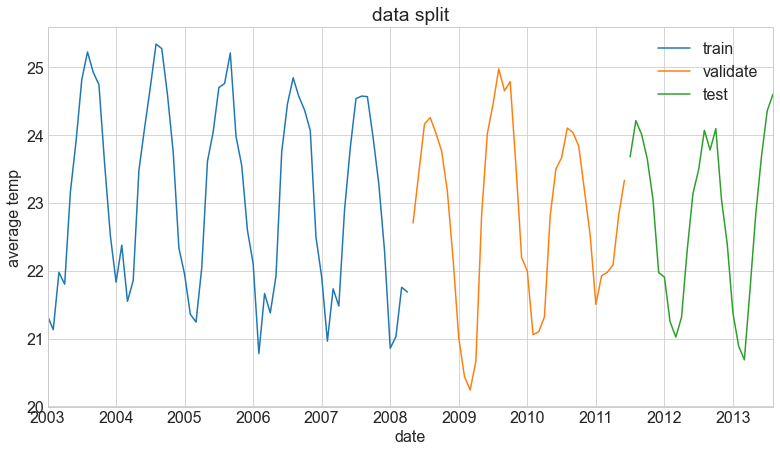

In [25]:
#Let's plot our data first, viewing where the data is split into train and test.
train.average_temp.plot(label = "train")
validate.average_temp.plot(label = "validate")
test.average_temp.plot(label = "test")
plt.legend()
plt.ylabel("average temp")
plt.title("data split")
plt.show()

### Exploration

In [26]:
#our target is average temperature
y = train.average_temp
y.head(2)

date
2003-01-01    21.337
2003-02-01    21.132
Name: average_temp, dtype: float64

In [27]:
#what is our min and max temperature
y.min(), y.max()

(20.781, 25.342)

[]

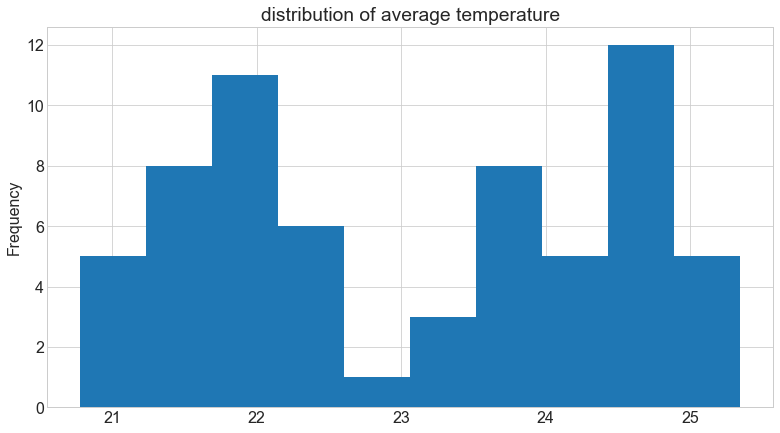

In [28]:
#lets see distriburiton of target
y.plot.hist(title ="distribution of average temperature")
plt.plot()

    temp ranges between 20.8 and  25.3 celusis

[]

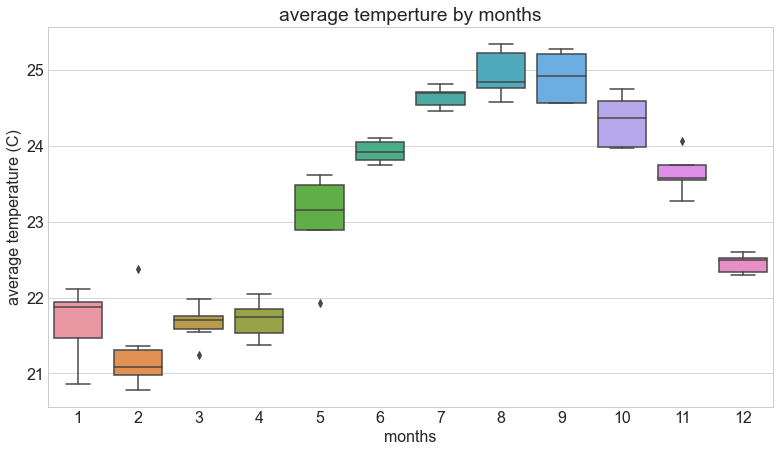

In [29]:
#average temp by months()
sns.boxplot(data = train, x = train.index.month, y = 'average_temp')
plt.title("average temperture by months")
plt.xlabel("months")
plt.ylabel("average temperature (C)")
plt.plot()

        july, august, september and october are hot months. its a great place to skip winter at north.
        few outliers are also present

Seasonal plot

[]

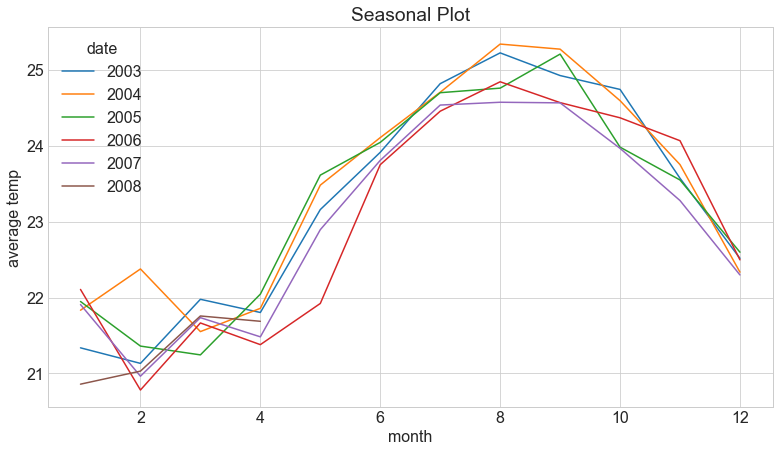

In [30]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot',\
                                                                xlabel = "month",\
                                                                ylabel = "average temp")
plt.plot()

    temperature follow the monthly cycle. 
    2004 had some hottest months

### Seasonal decomposition

In [31]:
#this gives us trend, seasonality and residual
y = train.average_temp.resample('M').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
2003-01-31,21.337,NaN,-1.288142,NaN
2003-02-28,21.132,NaN,-1.857173,NaN
2003-03-31,21.977,NaN,-1.668142,NaN
2003-04-30,21.803,NaN,-1.514048,NaN
2003-05-31,23.160,NaN,-0.215642,NaN


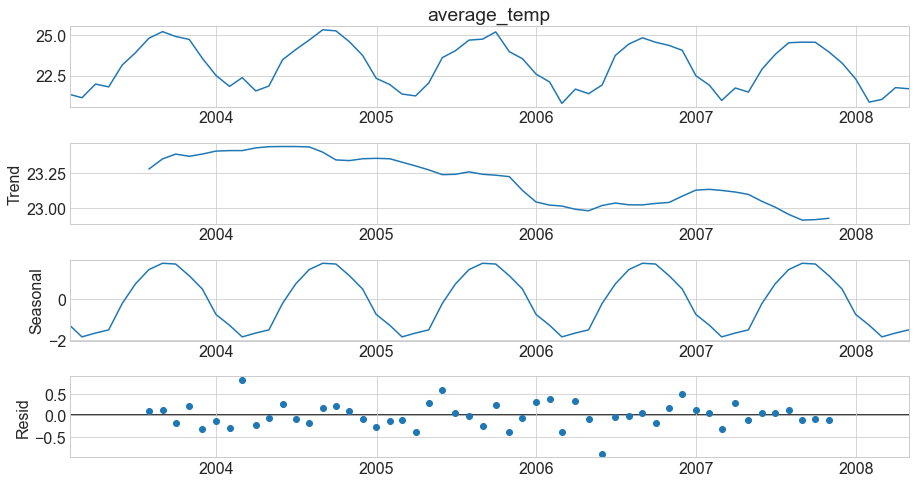

In [32]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

    surprisingly average temperate in hawaii slightly dropped (better than elevated)
    we can see a good seansonality

### Modeling

In [33]:
#  evaluation function to compute rmse
def evaluate(target_var):
    #function to calculate and return rmse
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [34]:
# plot and evaluate 
def plot_and_eval(target_var):
    #fucntion to plot train,validate and prediction
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE:', rmse)
    plt.show()

In [35]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [36]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Forecast

##### Last observed value
Use last observed average temperature

In [37]:
#last value of average temp
last_observed = train["average_temp"][-1:][0]
last_observed

21.687

In [38]:
yhat_df = pd.DataFrame(
    {'average_temp': [last_observed]},
    index=validate.index)

yhat_df.head(2)

,average_temp
date,
2008-05-01,21.687
2008-06-01,21.687


###### Plot Actual vs. Predicted Values

average_temp -- RMSE: 1.7348


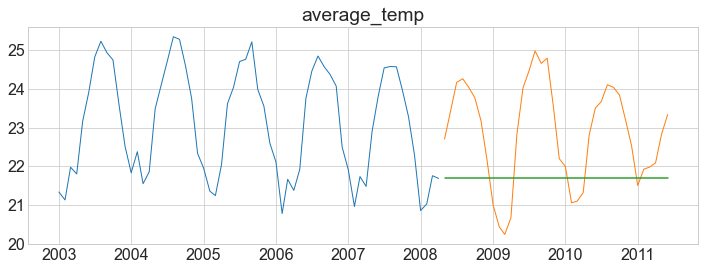

In [39]:
plot_and_eval("average_temp")

In [40]:
eval_df = append_eval_df("last observed", "average_temp")
eval_df

,model_type,target_var,rmse
0,last observed,average_temp,1.7348


##### Simple average
Taking mean of average temperature

In [41]:
#take mean of average temperature
simple_average = round(train.average_temp.mean(),2)

In [42]:
yhat_df = pd.DataFrame(
    {'average_temp': [simple_average]},
    index=validate.index)

yhat_df.head(2)

,average_temp
date,
2008-05-01,23.08
2008-06-01,23.08


###### Plot Actual vs. Predicted Values

average_temp -- RMSE: 1.3066


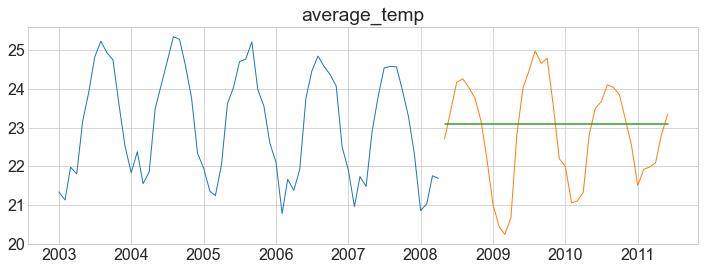

In [43]:
plot_and_eval("average_temp")

In [44]:
#add into the table
eval_df= append_eval_df("simple average", "average_temp")
eval_df

,model_type,target_var,rmse
0,last observed,average_temp,1.7348
1,simple average,average_temp,1.3066


##### Moving average
Use a 3 month moving average

In [45]:
#set period = 3
period = 3
#take 3 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
moving_average = round(train["average_temp"].rolling(3).mean()[-1],4)
moving_average

21.4913

In [46]:
yhat_df = pd.DataFrame(
    {'average_temp': [moving_average]},
    index=validate.index)

yhat_df.head(2)

,average_temp
date,
2008-05-01,21.4913
2008-06-01,21.4913


###### Plot Actual vs. Predicted Values

average_temp -- RMSE: 1.8717


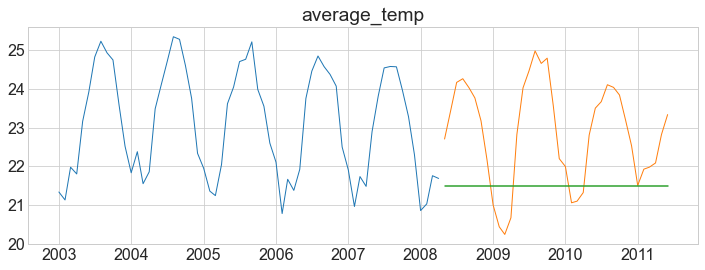

In [47]:
plot_and_eval("average_temp")

In [48]:
#add into the table
eval_df= append_eval_df("3 months moving average", "average_temp")
eval_df

,model_type,target_var,rmse
0,last observed,average_temp,1.7348
1,simple average,average_temp,1.3066
2,3 months moving average,average_temp,1.8717


#### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend 

In [49]:
model = Holt(train["average_temp"], exponential = False)
model = model.fit(smoothing_level = .1,
                    smoothing_slope = .1,
                    optimized = False)
yhat_items = model.predict(start = validate.index[0],
                            end = validate.index[-1])
yhat_df["average_temp"] = round(yhat_items, 2)

In [50]:
yhat_df.head(2)

,average_temp
date,
2008-05-01,22.44
2008-06-01,22.38


average_temp -- RMSE: 2.0047


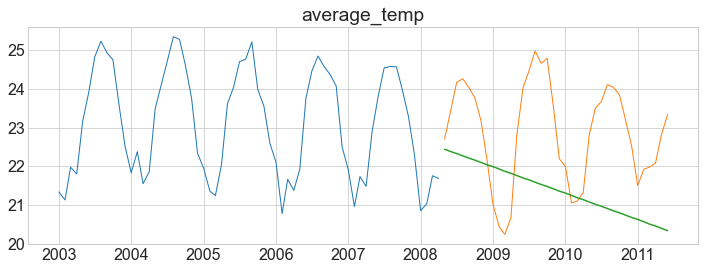

In [51]:
plot_and_eval("average_temp")

In [52]:
#add into the table
eval_df= append_eval_df("Holt's Linear Trend", "average_temp")
eval_df

,model_type,target_var,rmse
0,last observed,average_temp,1.7348
1,simple average,average_temp,1.3066
2,3 months moving average,average_temp,1.8717
3,Holt's Linear Trend,average_temp,2.0047


Our best model seems to be Simple Average

In [53]:
#prediction using simple average
yhat_df_test = pd.DataFrame(
    {'average_temp': [simple_average]},
    index=test.index)
#prediction
yhat_df_test.head(5)

,average_temp
date,
2011-07-01,23.08
2011-08-01,23.08
2011-09-01,23.08
2011-10-01,23.08
2011-11-01,23.08


In [54]:
#rmse on test data
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df_test[target_var])), 4)
    return rmse

print("rmse on test is :", evaluate("average_temp"))

rmse on test is : 1.2323


In [55]:
#function to plot entire dataset
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df_test, alpha=.5, label ="prediction")
    plt.title(target_var)
    plt.legend()
    plt.show()

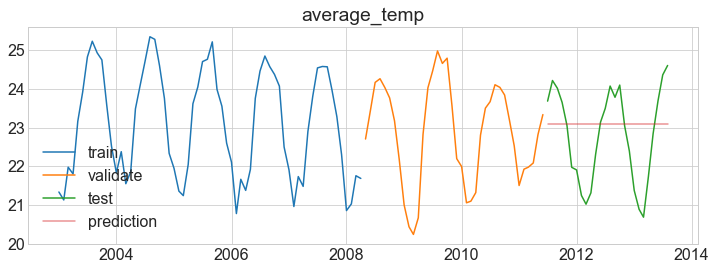

In [56]:
#plot with test prediction
final_plot("average_temp")

### Conclusion:

> - The best model to be used for future predictions was the Simple Average Model.
> - The Simple Average model had the loweset RMSE score of 1.3066 and on test in 1.2323